In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
from datetime import date, datetime, timedelta
from datetime import time as dttime
import time
import yfinance as yf
from pyetfdb_scraper import etf
from IPython.display import clear_output
import requests
from bs4 import BeautifulSoup
import zipfile
from io import BytesIO

from keras.models import Sequential
from keras.layers import LSTM, Dense

import relative_value as rv

from plotly.offline import iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import vix_utils as vix

import asyncio 
import nest_asyncio
nest_asyncio.apply()

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import selenium.common.exceptions

from tqdm import tqdm

chrome_options = Options()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--start-maximized')
chrome_options.page_load_strategy = 'eager'


from statsmodels.graphics.tsaplots import plot_acf


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import metrics
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

2023-12-01 00:40:18.239567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 00:40:18.356768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 00:40:18.931389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 00:40:18.932690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 00:40:20.807197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import tensorflow as tf
print(tf.__version__) # check the version (should be 2.x+)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

2.13.0


In [ ]:

df = yf.Ticker('UVXY').history(start=datetime(2020,1,1), end=datetime.today(), interval='1d')

df = df.drop(['High', 'Low','Dividends','Stock Splits','Capital Gains','Volume'],axis=1)
df['return_close_close'] = df['Close'].pct_change()
df['return_overnight'] = (df['Open'] - df['Close'].shift(1))/df['Close'].shift(1)
df['return_open_close'] = (df['Close'] - df['Open'])/df['Open']

df.index = df.index.tz_localize(None)

In [ ]:
yf.Ticker('^VOLI').history(start=datetime(2020,1,1), end=datetime.today(), interval='1d')

In [ ]:
px.violin(df[['return_close_close', 'return_overnight', 'return_open_close']])

In [ ]:
#vix_contango = rv.get_historical_vix_contango(datetime(2022,1,1), datetime.today())
vix_contango = pd.read_csv('VIX_Contango/vix_contango_2020-1-1_2023-6-30', index_col=0)

In [ ]:
vix_contango.index = pd.to_datetime(vix_contango.index).tz_localize(None)

In [ ]:
vix_hist = yf.Ticker('^VIX').history(period='max')

In [ ]:
vix_hist.index = vix_hist.index.tz_localize(None)

In [ ]:
df = df.join(vix_contango).join(vix_hist['Close'].rename('VIX_Spot'))

In [ ]:
df = df.rename(columns = {'7':'1-2_raw','8':'2-3_raw','9':'3-4_raw','10':'4-5_raw','11':'5-6_raw','12':'6-7_raw','13':'7-8_raw'})

In [ ]:
df = df.replace('%','',regex=True)

In [ ]:
df = df.apply(pd.to_numeric)

In [ ]:
px.line(df, x=df.index, y='return_overnight')

In [ ]:
px.line(df, x=df.index, y='1-2')

In [ ]:
df['day_of_month'] = df.index.day

In [ ]:
df[['1-2_prev','2-3_prev','3-4_prev','4-5_prev','5-6_prev','6-7_prev','7-8_prev','VIX_Spot_prev']] = \
    df[['1-2','2-3','3-4','4-5','5-6','6-7','7-8','VIX_Spot']].shift(1)

In [ ]:
df[['1-2_raw_prev','2-3_raw_prev','3-4_raw_prev','4-5_raw_prev','5-6_raw_prev','6-7_raw_prev','7-8_raw_prev']] = \
    df[['1-2_raw','2-3_raw','3-4_raw','4-5_raw','5-6_raw','6-7_raw','7-8_raw']].shift(1)

In [ ]:
px.scatter(df,x='VIX_Spot_prev',y='return_overnight')

In [ ]:
econ_df = pd.read_csv('calendar-event-list (1).csv', index_col=1)

In [ ]:
econ_df.index = pd.to_datetime(econ_df.index).date

In [ ]:
econ_df = econ_df[econ_df['Impact'].isin(['HIGH'])]

In [ ]:
df = df.join(econ_df, how='left')

In [ ]:
df['macro_event'] = np.where(df['Impact']=='HIGH', 1, 0)

In [ ]:
df = df.drop(['Id','Name','Impact','Currency'], axis=1).drop_duplicates()

In [ ]:
df['macro_event_next_day'] = df['macro_event'].shift(-1)

In [ ]:
df = df.fillna(axis=0, method='ffill').dropna(axis=0)

In [ ]:
df['return_overnight_gt_5'] = np.where(df['return_overnight'] >= 0.05, 1, 0)

In [ ]:
X = df.drop(['Open','Close','return_close_close', 'return_overnight', 'return_open_close', 'return_overnight_gt_5', '1-2','2-3','3-4','4-5','5-6','6-7','7-8',\
'1-2_raw','2-3_raw','3-4_raw','4-5_raw','5-6_raw','6-7_raw','7-8_raw','VIX_Spot'], axis=1).values
y = df['return_overnight_gt_5'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=90)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
pd.Series(model.feature_importances_*100, index = df.drop(['Open','Close','return_close_close', 'return_overnight', 'return_open_close', 'return_overnight_gt_5', '1-2','2-3','3-4','4-5','5-6','6-7','7-8',\
'1-2_raw','2-3_raw','3-4_raw','4-5_raw','5-6_raw','6-7_raw','7-8_raw','VIX_Spot'], axis=1).columns)

In [ ]:
np.corrcoef(y_pred,y_test)

In [ ]:
predictions = pd.DataFrame([y_pred, y_test], index=['y_pred','y_test']).T

In [ ]:
px.scatter(df,df.index,'return_close_close', color='macro_event')

In [ ]:
px.scatter(predictions,'y_pred','y_test')

In [ ]:
metrics.r2_score(y_test,y_pred)

In [ ]:
predictions[predictions['y_pred']==1]

In [ ]:
df = pd.read_csv('uvxy_spy_vixfutures.csv')

In [ ]:
df['10DTE PnL'] = pd.to_numeric(df['10DTE PnL'].str.replace('$','').str.replace(',',''))
df['UVXY IV Rank'] = pd.to_numeric(df['UVXY IV Rank'].str.replace('%',''))
df['SPY Rolling 5D Ret'] = pd.to_numeric(df['SPY Rolling 5D Ret'].str.replace('%',''))

In [ ]:
df.set_index('Expiration Date', inplace=True)

In [ ]:
df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)

df_train.describe().transpose()


In [ ]:
features_train = df_train.copy()
features_test = df_test.copy()

labels_train = features_train.pop('10DTE PnL')
labels_test = features_test.pop('10DTE PnL')

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(features_train))
first = np.array(features_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

In [ ]:
model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
model.compile(loss='mean_absolute_error',
                optimizer='Adam')

In [ ]:
history = model.fit(
    features_train,
    labels_train,
    validation_split=0.2,
    verbose=0, epochs=250)

In [ ]:
test_results = model.evaluate(features_test, labels_test, verbose=1)

In [ ]:
test_predictions = model.predict(features_test).flatten()
train_predictions = model.predict(features_train).flatten()

a = plt.axes()
plt.scatter(labels_test, test_predictions)
plt.xlabel('True Values [PnL]')
plt.ylabel('Predictions [PnL]')
plt.show()

In [ ]:
a = plt.axes()
plt.scatter(labels_train, train_predictions)
plt.xlabel('True Values [PnL]')
plt.ylabel('Predictions [PnL]')
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [PnL]')
plt.legend()
plt.grid(True)

In [ ]:
import nasdaqdatalink as ndl
import os
ndl.ApiConfig.api_key = os.environ['ndl_api_key']

In [3]:
iv30_df = pd.read_csv('IV_Data_2023-04-05/iv_30.csv').set_index('date')
iv60_df = pd.read_csv('IV_Data_2023-04-05/iv_60.csv').set_index('date')
iv90_df = pd.read_csv('IV_Data_2023-04-05/iv_90.csv').set_index('date')

In [4]:
iv_df = iv30_df.join(iv60_df, rsuffix='_60')

In [5]:
iv_df = iv_df.join(iv90_df, rsuffix='_90')

In [6]:
uvxy = yf.Ticker('UVXY').history(start=datetime(2022,1,1), end=datetime.today(), interval='1d')['Close'].pct_change().shift(-1).rename('UVXY')

In [7]:
return_df = pd.read_csv('IV_Data_2023-04-05/stockpx.csv').set_index('date')

In [8]:
return_df = return_df.pct_change()

In [9]:
uvxy.index = pd.to_datetime(uvxy.index.date)

In [10]:
df = iv_df.join(return_df, lsuffix = '_30', rsuffix='_return')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df.join(uvxy)

In [11]:
df = df.rename(columns={'UVXY': 'UVXY_nextdayreturn'})

In [ ]:
df.to_csv('lstm_df.csv')

In [ ]:
df = df.fillna(method='ffill').fillna(method='bfill')

df_train = df.iloc[:int(len(df)*.8),:]
df_test = df.drop(df_train.index)

In [ ]:
features_train = df_train.copy().fillna(method='ffill').fillna(method='bfill')
features_test = df_test.copy().fillna(method='ffill').fillna(method='bfill')

labels_train = features_train.pop('UVXY_nextdayreturn')
labels_test = features_test.pop('UVXY_nextdayreturn')

features_train = np.array(features_train)
labels_train = np.array(labels_train)


features_test = np.array(features_test)
labels_test = np.array(labels_test)

In [12]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


In [ ]:

# Example usage
time_steps = 5  # Number of time steps (days) you want to consider
features_train_reshaped, labels_train_reshaped = create_dataset(features_train, labels_train, time_steps)
features_test_reshaped, labels_test_reshaped = create_dataset(features_test, labels_test, time_steps)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(5, 4576), return_sequences=True), 
    tf.keras.layers.LSTM(64, return_sequences=True), 
    tf.keras.layers.LSTM(128, return_sequences=True), 
    tf.keras.layers.LSTM(256, return_sequences=False), 
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dense(1),
])
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

In [ ]:
history = model.fit(
    features_train_reshaped,
    labels_train_reshaped,
    verbose=1, epochs=500, batch_size = 32, validation_split=0.2)

In [ ]:
test_results = model.evaluate(features_test_reshaped, labels_test_reshaped, verbose=1)

In [ ]:
test_predictions = model.predict(features_test_reshaped)
train_predictions = model.predict(features_train_reshaped)

a = plt.axes()
plt.scatter(labels_test_reshaped, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
a = plt.axes()
plt.scatter(labels_train_reshaped, train_predictions)
plt.xlabel('True Values [PnL]')
plt.ylabel('Predictions [PnL]')
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [PnL]')
plt.legend()
plt.grid(True)

In [13]:
def preprocess_data(df, ticker, time_steps=5, train_split=0.8):
    df_sub = df[[col for col in df.columns if col.startswith(f'{ticker}_')]]
    df_sub['nextdayiv90'] = df_sub[f'{ticker}_90'].shift(-1)
    df_sub = df_sub.fillna(method='ffill').fillna(method='bfill')

    features_train = df_sub.iloc[:int(len(df_sub)*train_split),:]
    features_test = df_sub.drop(features_train.index)
    labels_train = features_train.pop('nextdayiv90')
    labels_test = features_test.pop('nextdayiv90')

    features_train = np.array(features_train)
    labels_train = np.array(labels_train)
    features_test = np.array(features_test)
    labels_test = np.array(labels_test)

    features_train_reshaped, labels_train_reshaped = create_dataset(features_train, labels_train, time_steps)
    features_test_reshaped, labels_test_reshaped = create_dataset(features_test, labels_test, time_steps)

    return features_train_reshaped, labels_train_reshaped, features_test_reshaped, labels_test_reshaped

In [23]:
def build_and_fit_model(features_train, labels_train, loss_function, learning_rate=0.001, epochs=500, batch_size=32, time_steps=5):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(time_steps, 4), return_sequences=True), 
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dense(1),
    ])
    model.compile(loss=loss_function,
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
    
    history = model.fit(
        features_train,
        labels_train,
        verbose=1, epochs=epochs, batch_size = batch_size)
    
    return model, history

In [20]:
def evaluate_model(model, history, features_train, labels_train, features_test, labels_test, return_plots=False):
    test_results = model.evaluate(features_test, labels_test, verbose=1)

    test_predictions = model.predict(features_test)
    train_predictions = model.predict(features_train)


    plt.ioff() 
    
    test_plot = plt.figure()
    plt.scatter(labels_test, test_predictions)
    plt.xlabel('True Values (Test Data)')
    plt.ylabel('Predictions')
    #plt.show()

    train_plot = plt.figure()
    plt.scatter(labels_train, train_predictions)
    plt.xlabel('True Values (Train Data)')
    plt.ylabel('Predictions')
    #plt.show()

    history_plot = plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()

    if return_plots:
        return test_results, test_plot, train_plot, history_plot 

In [16]:
volumes = {}
for ticker in tqdm(pd.read_csv('IV_Data_2023-04-05/stockpx.csv').set_index('date').columns):
    print(ticker)
    volume = yf.download(ticker, start=datetime.today()-timedelta(10), interval='1d', progress=False)['Volume']
    if len(volume > 0): 
        volumes[ticker] = volume.mean()
    else:
        pass
    clear_output()

100%|██████████| 1144/1144 [02:49<00:00,  6.73it/s]


In [17]:
ticker_volumes = pd.Series(volumes).sort_values(ascending=False)

In [24]:

plt.ioff() 
results = {}
for ticker in tqdm(ticker_volumes.index[:20]):
    print(ticker)
    features_train, labels_train, features_test, labels_test = preprocess_data(df, ticker, time_steps=5)
    model, history = build_and_fit_model(features_train, labels_train, loss_function = 'mean_absolute_percentage_error',
                                          learning_rate=0.01, epochs=50, batch_size=32, time_steps=5)
    results[ticker] = evaluate_model(model, history, features_train, labels_train, features_test, labels_test, return_plots=True)
    clear_output()
    print(f'{ticker}: {results[ticker][0]}')

100%|██████████| 20/20 [02:24<00:00,  7.24s/it]

NIO: 7.439387321472168


In [25]:
res = pd.Series({ticker: results[ticker][0] for ticker in results.keys()}).sort_values()

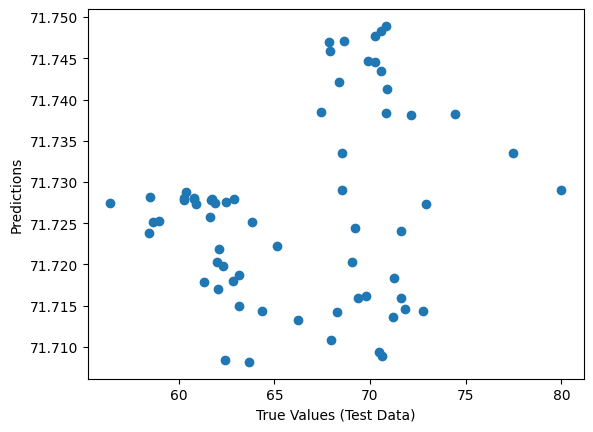

In [32]:
ticker = 'SOFI'
results[ticker][1]

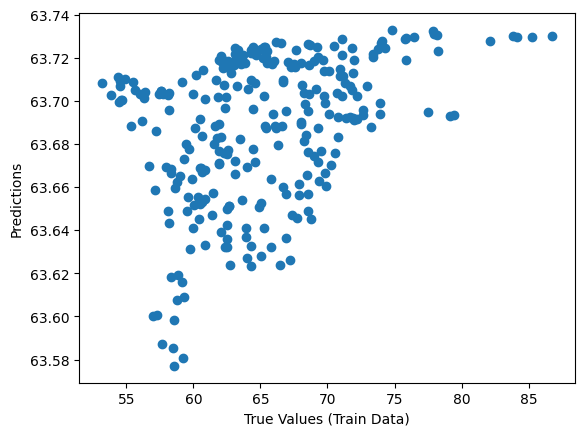

In [30]:
results[ticker][2]

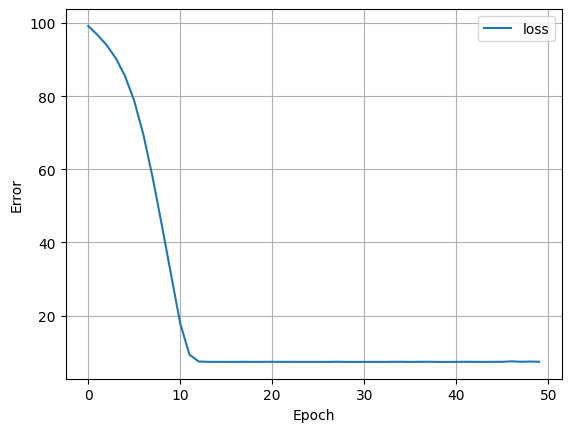

In [31]:
results[ticker][3]